# INTRODUCTION

In this notebook we present the full analysis from EDA to predictions by explaining all the steps, of the housing database






In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


**Database exploration**

In [2]:
df = pd.read_csv('train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

**Removing the Id column and eventual duplicates**

In [3]:
df.drop('Id', axis=1, inplace=True)
df = df.drop_duplicates()

# EDA NUMERICAL COLUMNS

We will start by splitting the database in categorical and numerical part, first of all we are going to explore the numerical columns.

In [4]:
df_numerical = df.select_dtypes(['int64', 'float64'])
df_categorical = df.select_dtypes(['object'])



**Target variable: SalePrice**

Let us start our analysis from the target variable 'SalePrice';when we prepare our data for a regression model a desirable feature is our target variable to follow a normal distribution, in this way the power of statistical inference can be fully unleashed, allowing us to evaluate analytically the significance of the parameters we aim to estimate.

To assess the normality of the "SalePrice' column I will plot an histogram followed by a QQ-plot:
* The histogram may be helpful to have a qualitative understanding of the shape of the distribution
* The QQ plot compare the theoretical quantiles of a standardized normal variable with the quantiles of our data

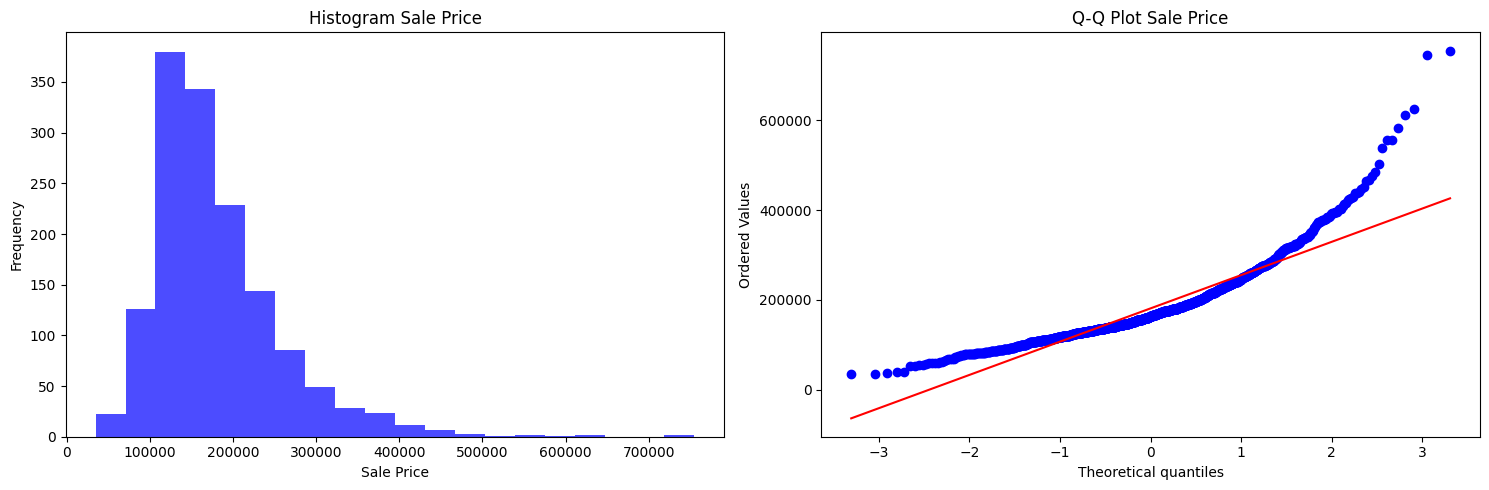

In [5]:
from scipy.stats import probplot

fig, axes = plt.subplots(1, 2, figsize=(15, 5))


axes[0].hist(df_numerical['SalePrice'], bins=20, color='blue', alpha=0.7)
axes[0].set_title('Histogram Sale Price')
axes[0].set_xlabel('Sale Price')
axes[0].set_ylabel('Frequency')


probplot(df_numerical['SalePrice'], plot=axes[1], dist='norm', fit=True)
axes[1].set_title('Q-Q Plot Sale Price')


plt.tight_layout()
plt.show()

The distribution exhibits a positive skewness, as the Q-Q plot confirms this suggest a departure from a normal distribution, however in this case we may look for some transformations to symmetrize the distribution of our data. In a case like this, where the skewness is positive, a log transformation often proves to be a consistent approach.

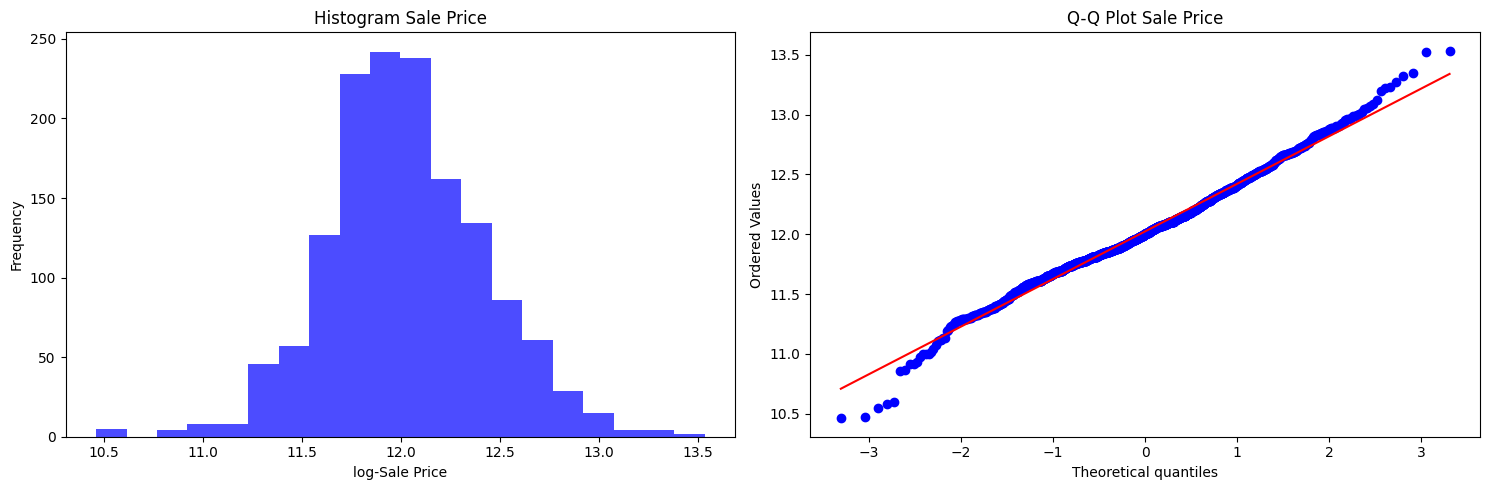

In [6]:

df_numerical['SalePrice'] = np.log(df_numerical['SalePrice'])


fig, axes = plt.subplots(1, 2, figsize=(15, 5))


axes[0].hist(df_numerical['SalePrice'], bins=20, color='blue', alpha=0.7)
axes[0].set_title('Histogram Sale Price')
axes[0].set_xlabel('log-Sale Price')
axes[0].set_ylabel('Frequency')


probplot(df_numerical['SalePrice'], plot=axes[1], dist='norm', fit=True)
axes[1].set_title('Q-Q Plot Sale Price')


plt.tight_layout()
plt.show()


Much better!

As a university professor used to say when we are in a Gaussian world above 2.5/3-sigma you may find elves and other mythic creatures, that's why rows leading to data above this threshold are stronger candidates for outliers.

The strategy here will be to remove the rows corresponding to these data points since they lead to prediction which do not capture the central tendency of the target variables and this may be a source of errors for our model.

To do this we will introduce a standarized variable often called Z and we will consider outliers the rows above a certain number of std deviations.

Since we split the database we have to collect the index of these rows to remove them for consistency even in the categorical database.



In [7]:
mean_estimate = df_numerical['SalePrice'].mean()
variance_estimate = df_numerical['SalePrice'].var()


std_dev_estimate = np.sqrt(variance_estimate)
df_numerical['z_score'] = (df_numerical['SalePrice'] - mean_estimate) / std_dev_estimate

std_dev_numbers=2.5


df_numerical=df_numerical[(np.abs(df_numerical['z_score']) <= std_dev_numbers)]
df_categorical=df_categorical[df_categorical.index.isin(df_numerical.index)]


df_numerical.drop('z_score', axis=1, inplace=True)
df_numerical = df_numerical.reset_index(drop=True)
df_categorical = df_categorical.reset_index(drop=True)


df_categorical.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1432 entries, 0 to 1431
Data columns (total 43 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSZoning       1432 non-null   object
 1   Street         1432 non-null   object
 2   Alley          88 non-null     object
 3   LotShape       1432 non-null   object
 4   LandContour    1432 non-null   object
 5   Utilities      1432 non-null   object
 6   LotConfig      1432 non-null   object
 7   LandSlope      1432 non-null   object
 8   Neighborhood   1432 non-null   object
 9   Condition1     1432 non-null   object
 10  Condition2     1432 non-null   object
 11  BldgType       1432 non-null   object
 12  HouseStyle     1432 non-null   object
 13  RoofStyle      1432 non-null   object
 14  RoofMatl       1432 non-null   object
 15  Exterior1st    1432 non-null   object
 16  Exterior2nd    1432 non-null   object
 17  MasVnrType     578 non-null    object
 18  ExterQual      1432 non-null

Let's verify the updated distribution and a boxplot to see if we have successfully removed the outliers

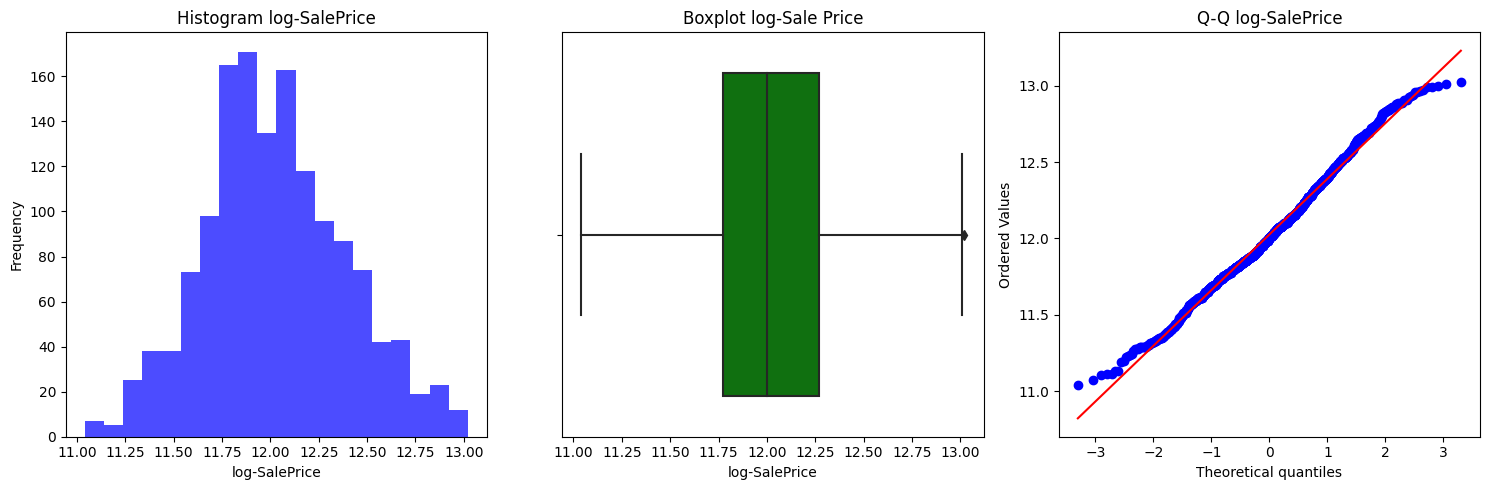

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))


axes[0].hist(df_numerical['SalePrice'], bins=20, color='blue', alpha=0.7)
axes[0].set_title('Histogram log-SalePrice')
axes[0].set_xlabel('log-SalePrice')
axes[0].set_ylabel('Frequency')


sns.boxplot(x=df_numerical['SalePrice'], ax=axes[1], color='green')
axes[1].set_title('Boxplot log-Sale Price')
axes[1].set_xlabel('log-SalePrice')


probplot(df_numerical['SalePrice'], plot=axes[2], dist='norm', fit=True)
axes[2].set_title('Q-Q log-SalePrice')


plt.tight_layout()
plt.show()

# LOW-VARIANCE COLUMNS NUMERICAL

Let's start to investigate our features, first of all we want remove 'low-variance' columns: imagine a features in a database with just one unique value, this feature is not going to add any predictivity to our model and the variance of the feature is going to be 0.

Let us use the following strategy:
1. Calculate the percentage of unique values for each different channel of all columns
2. Define a threshold percentage and select the columns with a value above the threshold.
3. Investigate the presence of potential outliers since they may have an impact on the calculation of the variance of the columns
4. Before removing the outliers since these columns have a high percentage of values concentrated in one 'channel', let use evaluate the correlation between the column and the target variable, the idea is to see if the low values'channels' of the same column give some useful info for our model. To do this we introduce a correlation threshold.
5. In the case where the correlation is smaller than the threeshold we may check the correlation between the columns and the target variables by removing the outliers with the IQR method 
6. If the correlation remain small the outliers might be removed since are not giving useful informations for the model. If the correlation increase after we dropped the outliers it might give us another reason to remove them. For column that have a correlation bigger than the threshold if we observe a significant drop in the correlation with the target variable after removing the outliers, it might be an indication that they can provide some useful information for our model.

All the thresolds that we are going to introduce have to be considered like parameter of the model.

In [9]:
percentage_threshold = 85
columns_above_PT = []


for column in df_numerical.columns:
    
    value_counts = df_numerical[column].value_counts()
    percentages = value_counts / len(df_numerical) * 100
    if percentages.max() >= percentage_threshold:
        columns_above_PT.append(column)
        

print(columns_above_PT)
        

['BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath', 'KitchenAbvGr', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']


Now we have a list of our columns, however before proceding further we have to identify potential outliers.


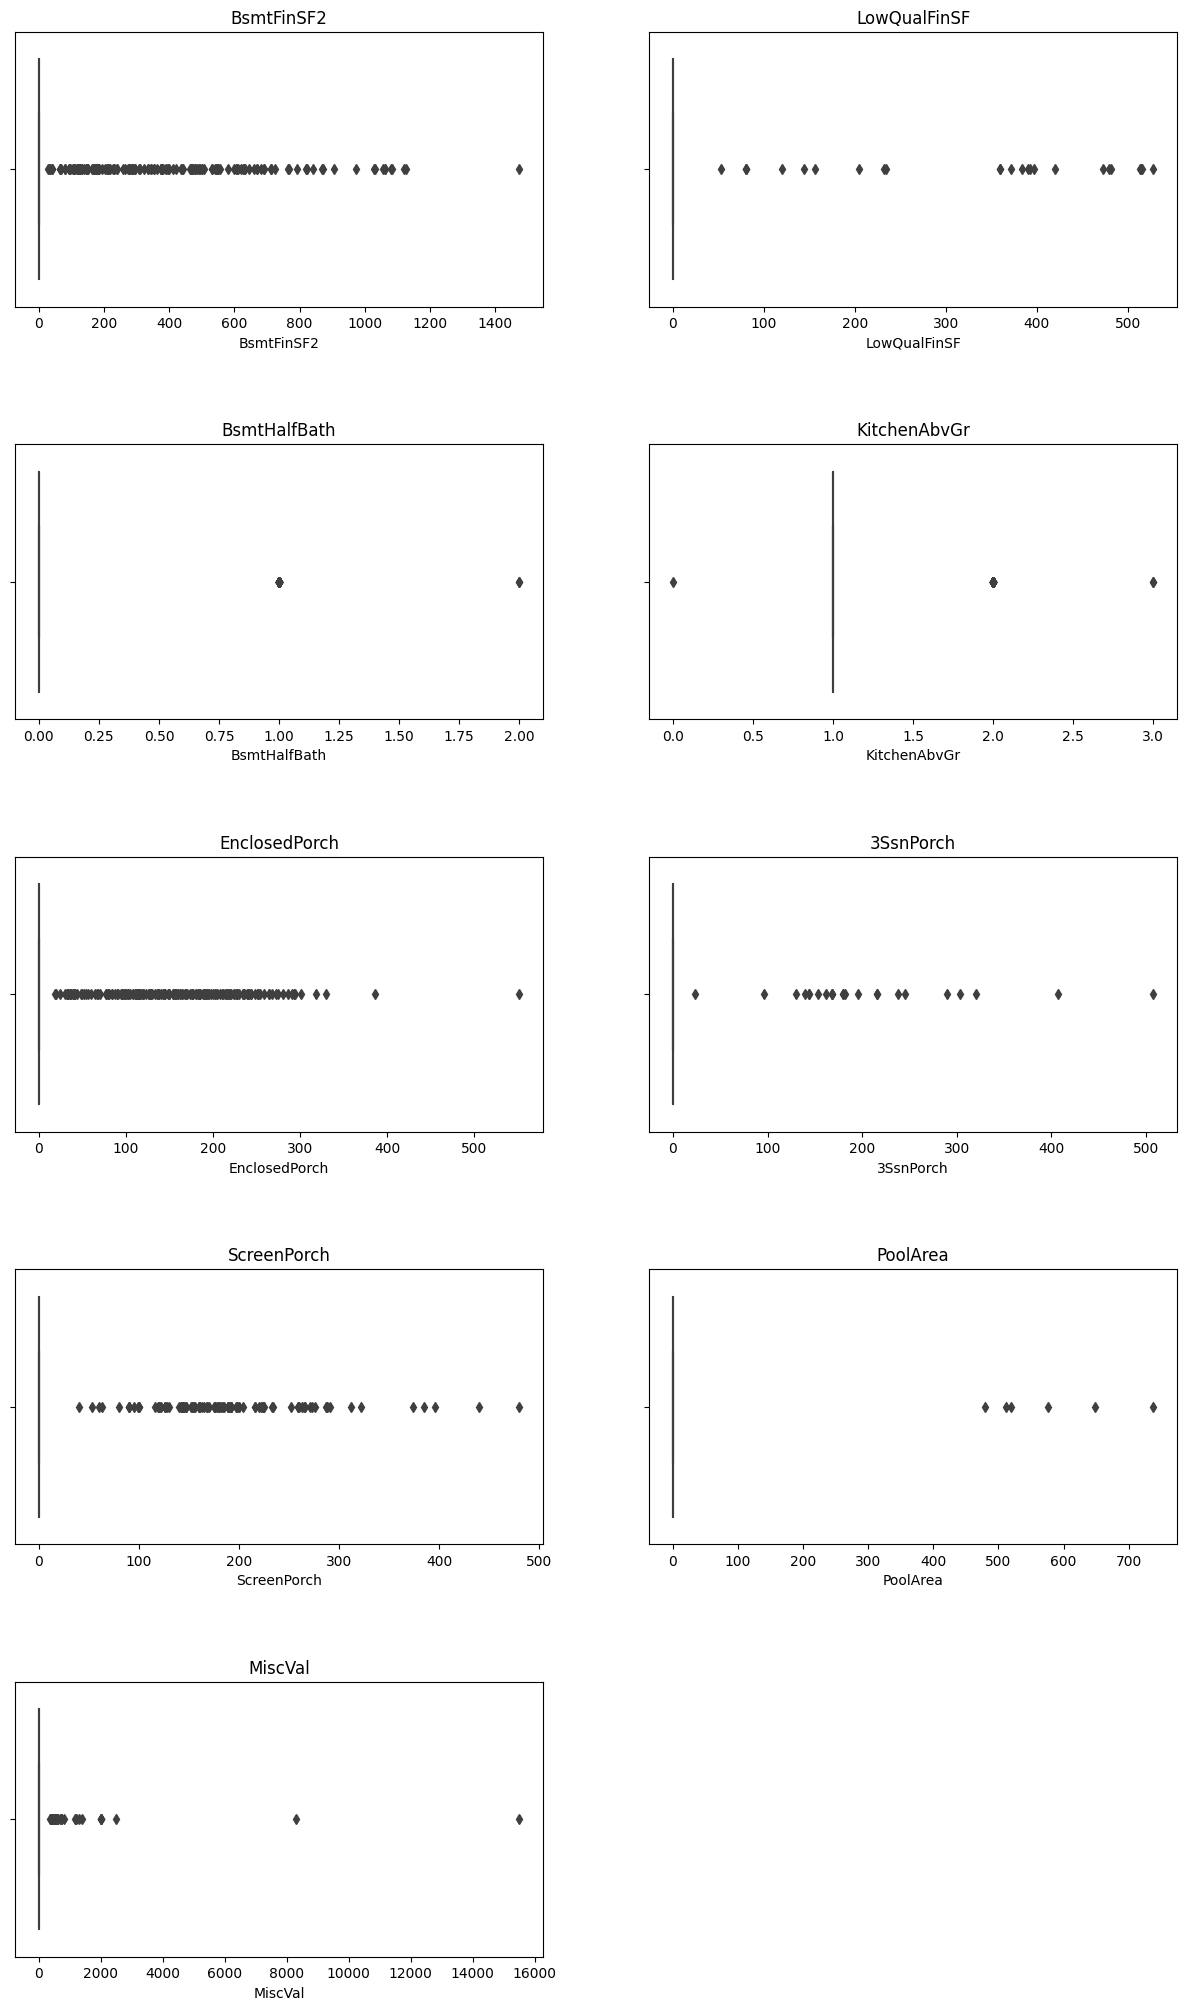

In [10]:
num_cols = len(columns_above_PT)
num_rows = (num_cols + 1) // 2  


fig, axes = plt.subplots(num_rows, 2, figsize=(15, 5 * num_rows))
fig.subplots_adjust(hspace=0.5)


for i, column in enumerate(columns_above_PT):
    row_index = i // 2
    col_index = i % 2
    sns.boxplot(x=df_numerical[column], ax=axes[row_index, col_index])
    axes[row_index, col_index].set_title(column)


if num_cols % 2 != 0:
    fig.delaxes(axes[-1, -1])


plt.show()

Since the majority of values is concentrated around 0, if we remove the outliers we are gonna probably have 0-variance columns, however as mentioned earlier, let us calculate if there is any correlation with the target variable.

In [11]:
correlation_threshold = 0.15
column_below_CT = []

for column in columns_above_PT:
    correlation=df['SalePrice'].corr(df[column])
    
    if correlation < correlation_threshold:
        column_below_CT.append(column)

print(column_below_CT)
    

['BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath', 'KitchenAbvGr', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']


Correlations are pretty weak, however to make the result more significant we would have to perform a statistical test. This is a possible weakness of the analysis.

Let us remove the outliers to see if there are some relevant changes of the correlations between these columns and the target

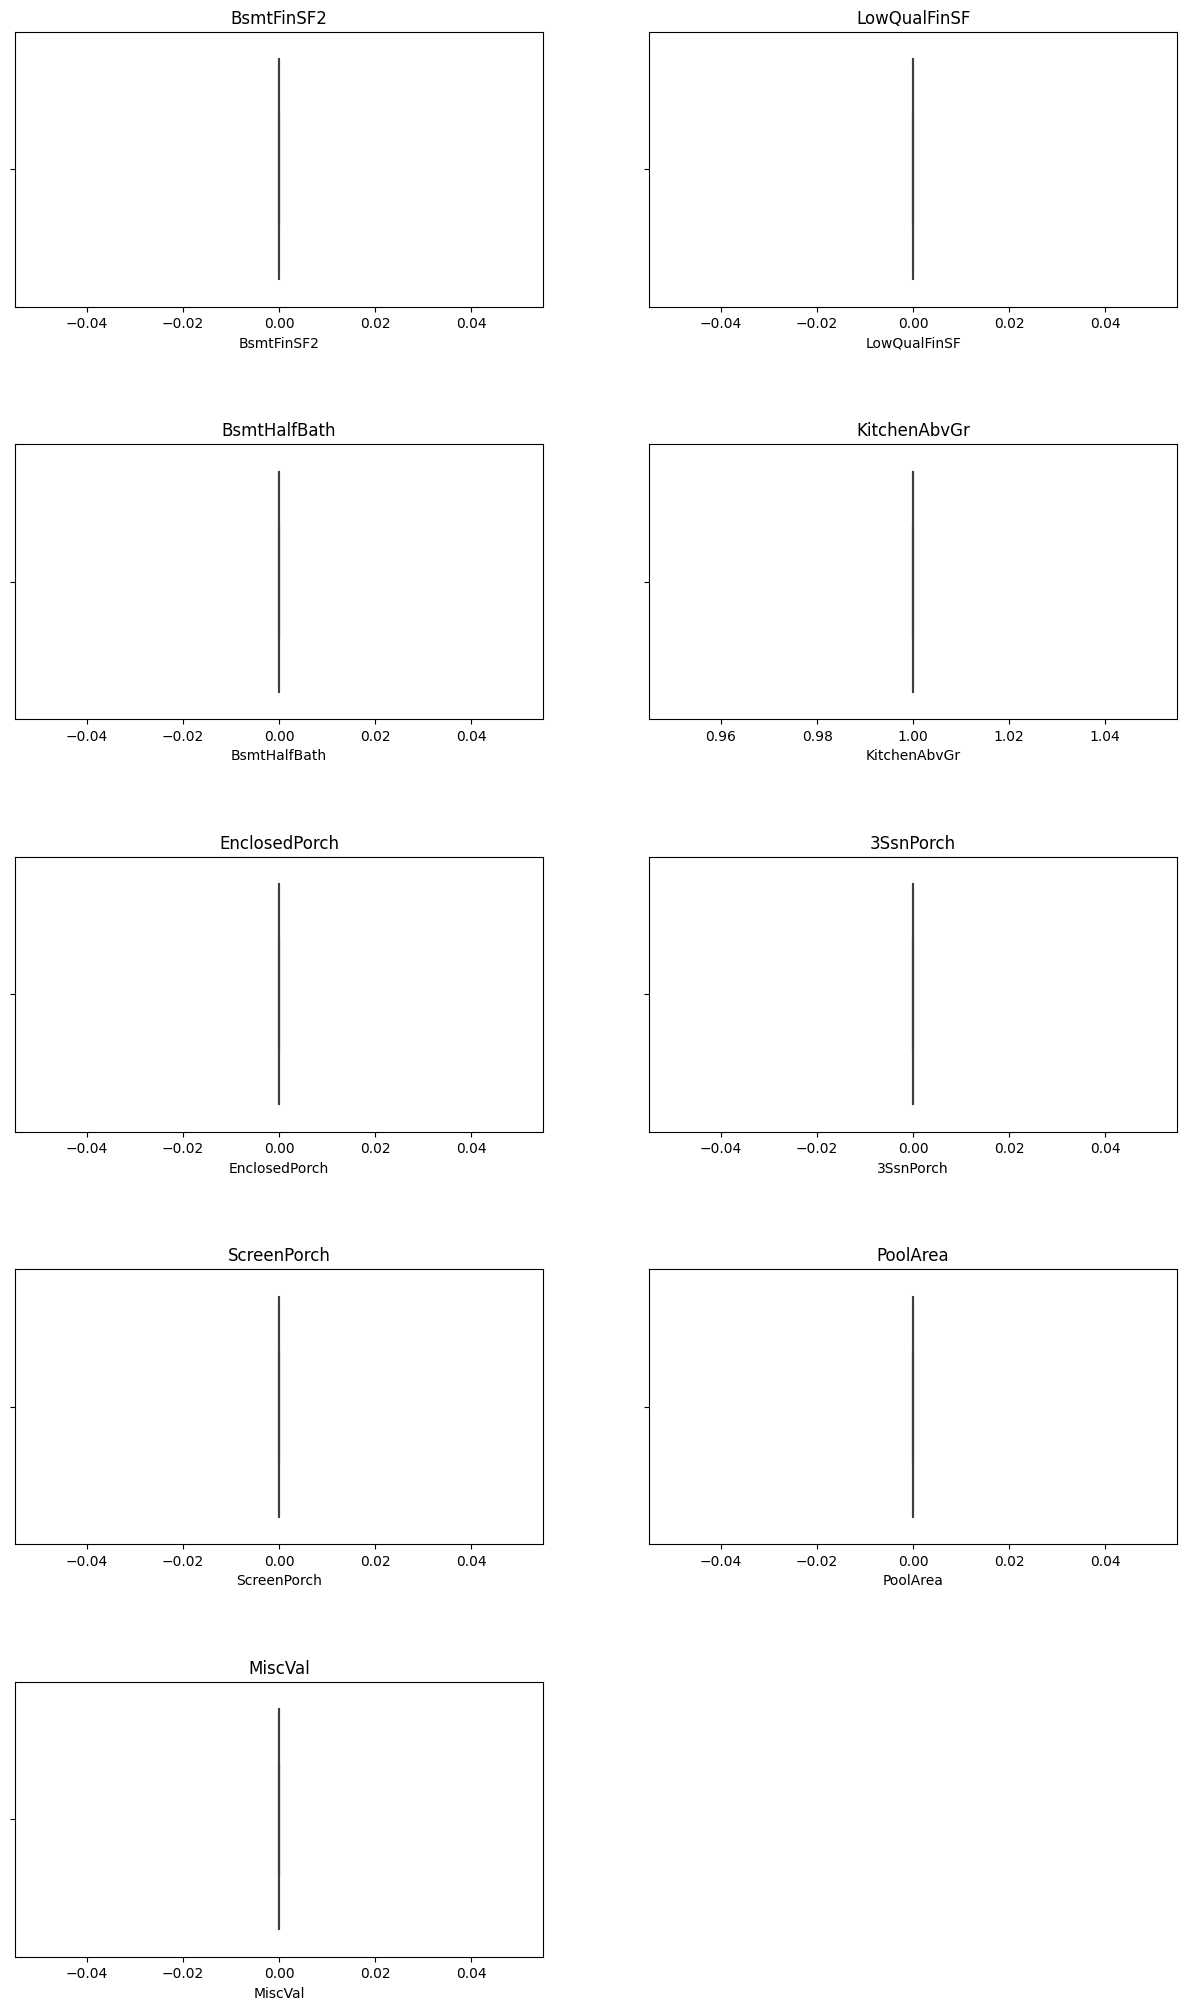

In [12]:
def remove_outliers_iqr(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return column[(column >= lower_bound) & (column <= upper_bound)]


for column in columns_above_PT:
    df_numerical[column] = remove_outliers_iqr(df[column])


num_cols = len(columns_above_PT)
num_rows = (num_cols + 1) // 2  


fig, axes = plt.subplots(num_rows, 2, figsize=(15, 5 * num_rows))
fig.subplots_adjust(hspace=0.5)


for i, column in enumerate(columns_above_PT):
    row_index = i // 2
    col_index = i % 2
    sns.boxplot(x=df_numerical[column], ax=axes[row_index, col_index])
    axes[row_index, col_index].set_title(column)


if num_cols % 2 != 0:
    fig.delaxes(axes[-1, -1])


plt.show()


After removing the outliers, these columns become zero-variance columns, and we are going to remove them since their correlation with the target is zero. As mentioned earlier, a low percentage of unique values outside the main channel for each column does not represent a central tendency of the data. Moreover, we verify that all the columns are weakly correlated with the target, and the presence of outliers does not result in a meaningful increase in correlation since all the columns are already below the correlation threshold

In [13]:
for column in column_below_CT:
    df_numerical.drop(column, axis=1, inplace=True)
  
    
df_numerical.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1432 entries, 0 to 1431
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MSSubClass    1432 non-null   int64  
 1   LotFrontage   1175 non-null   float64
 2   LotArea       1432 non-null   int64  
 3   OverallQual   1432 non-null   int64  
 4   OverallCond   1432 non-null   int64  
 5   YearBuilt     1432 non-null   int64  
 6   YearRemodAdd  1432 non-null   int64  
 7   MasVnrArea    1425 non-null   float64
 8   BsmtFinSF1    1432 non-null   int64  
 9   BsmtUnfSF     1432 non-null   int64  
 10  TotalBsmtSF   1432 non-null   int64  
 11  1stFlrSF      1432 non-null   int64  
 12  2ndFlrSF      1432 non-null   int64  
 13  GrLivArea     1432 non-null   int64  
 14  BsmtFullBath  1432 non-null   int64  
 15  FullBath      1432 non-null   int64  
 16  HalfBath      1432 non-null   int64  
 17  BedroomAbvGr  1432 non-null   int64  
 18  TotRmsAbvGrd  1432 non-null 

# A COMMON LOG-SCALE

Since we've applied a log-transformation to the target variable, we would like to have the same log-scale for all the features in the database. To do this I'm going to replace all the 0's in the various columns with the value 1. We don't have to worry about negative values of the features since they are positive definite.

Some extra reasons to apply a log transformation to the full dataset are the following:
* It helps to have a similar range for all the variables
* It takes care of potential outliers
* It helps to stabilize the variance of the variables and it helps to decrease the dependence of the variance from the features (heteroschedasticity)
* It helps to have more symmetric distribution of the features

For a regression problem these are highly desirable properties.

In [14]:
df_temp = df_numerical.copy()
df_numerical.drop('SalePrice', axis=1, inplace=True)


df_numerical.replace(0, 1, inplace=True)
df_numerical = np.log(df_numerical)

df_numerical['SalePrice'] = df_temp['SalePrice']


df_numerical.info()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1432 entries, 0 to 1431
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MSSubClass    1432 non-null   float64
 1   LotFrontage   1175 non-null   float64
 2   LotArea       1432 non-null   float64
 3   OverallQual   1432 non-null   float64
 4   OverallCond   1432 non-null   float64
 5   YearBuilt     1432 non-null   float64
 6   YearRemodAdd  1432 non-null   float64
 7   MasVnrArea    1425 non-null   float64
 8   BsmtFinSF1    1432 non-null   float64
 9   BsmtUnfSF     1432 non-null   float64
 10  TotalBsmtSF   1432 non-null   float64
 11  1stFlrSF      1432 non-null   float64
 12  2ndFlrSF      1432 non-null   float64
 13  GrLivArea     1432 non-null   float64
 14  BsmtFullBath  1432 non-null   float64
 15  FullBath      1432 non-null   float64
 16  HalfBath      1432 non-null   float64
 17  BedroomAbvGr  1432 non-null   float64
 18  TotRmsAbvGrd  1432 non-null 

# AVOIDING DATA LEAKAGE 1

All the previous operations we did to the database didn't involve calculation of collective quantities such as expected value, median and so on, for this reason we were working with the full dataset, however before dealing with the imputation of missing values we have to already split our database in the training and validation database to avoid data leakeage.

In [15]:
from sklearn.model_selection import train_test_split

X = df_numerical.drop('SalePrice', axis=1) 
y = df_numerical['SalePrice']  


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


df_numerical = X_train.copy()
df_numerical['SalePrice'] = y_train


df_numerical_test = X_test.copy()
df_numerical_test['SalePrice'] = y_test

# MISSING DATA

let us start by calculating the percentage of missing data for each column and let's analyze how they are distributed through histograms.

LotFrontage    209       18.25%
MasVnrArea     5         0.44%
GarageYrBlt    53        4.63%


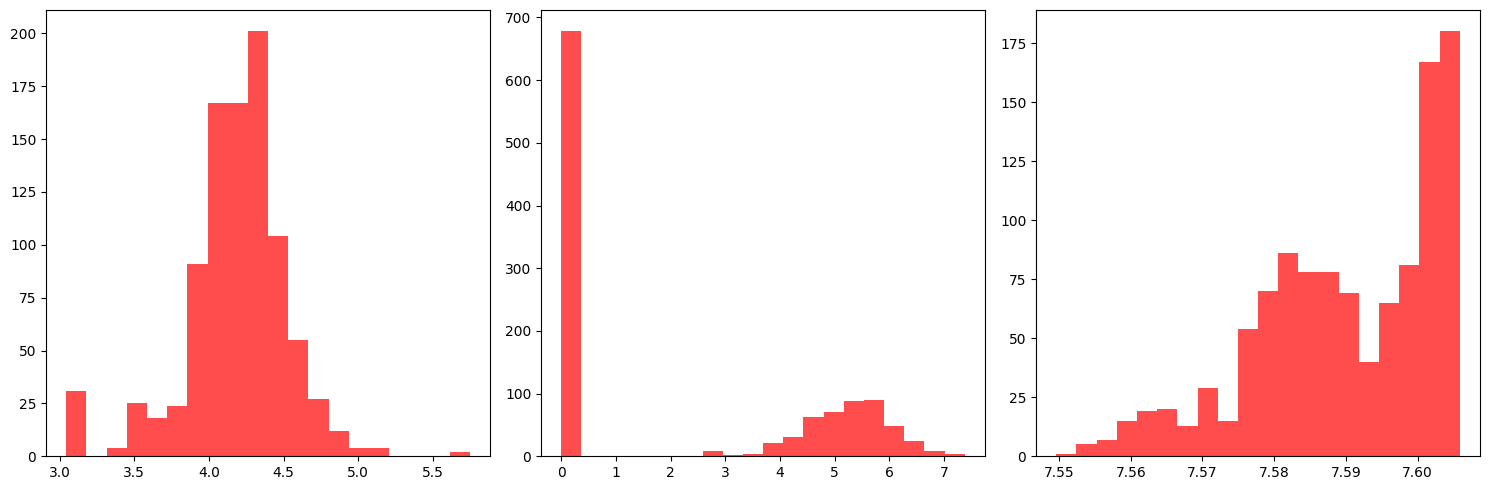

<class 'pandas.core.frame.DataFrame'>
Index: 1145 entries, 1142 to 1126
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MSSubClass    1145 non-null   float64
 1   LotFrontage   936 non-null    float64
 2   LotArea       1145 non-null   float64
 3   OverallQual   1145 non-null   float64
 4   OverallCond   1145 non-null   float64
 5   YearBuilt     1145 non-null   float64
 6   YearRemodAdd  1145 non-null   float64
 7   MasVnrArea    1140 non-null   float64
 8   BsmtFinSF1    1145 non-null   float64
 9   BsmtUnfSF     1145 non-null   float64
 10  TotalBsmtSF   1145 non-null   float64
 11  1stFlrSF      1145 non-null   float64
 12  2ndFlrSF      1145 non-null   float64
 13  GrLivArea     1145 non-null   float64
 14  BsmtFullBath  1145 non-null   float64
 15  FullBath      1145 non-null   float64
 16  HalfBath      1145 non-null   float64
 17  BedroomAbvGr  1145 non-null   float64
 18  TotRmsAbvGrd  1145 non-null   

In [16]:
numerical_missing = df_numerical[df_numerical.columns[df_numerical.isna().any()]]

for column in numerical_missing.columns:
    missing_values = numerical_missing[column].isnull().sum()
    percentage = (missing_values/df_numerical.shape[0])*100
    print(f"{column:<15}{missing_values:<10}{percentage:.2f}%")
    

fig,axes=plt.subplots(1,3,figsize=(15,5))


for i,columns in enumerate(numerical_missing.columns):
    axes[i].hist(x=df_numerical[columns], bins=20, color='red', alpha=0.7)
    
    
plt.tight_layout()
plt.show()



df_numerical.info()
    
    


Considering that all distributions of the data are skew, we might use KNN imputer since it is usually giving reasonable results and it is independent from the shape of distributions.

In [17]:
from sklearn.impute import KNNImputer


imputer = KNNImputer(n_neighbors=5)  
df_numerical = pd.DataFrame(imputer.fit_transform(df_numerical), columns=df_numerical.columns)
df_numerical_test = pd.DataFrame(imputer.fit_transform(df_numerical_test), columns=df_numerical_test.columns)


df_numerical.info()
df_numerical_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1145 entries, 0 to 1144
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MSSubClass    1145 non-null   float64
 1   LotFrontage   1145 non-null   float64
 2   LotArea       1145 non-null   float64
 3   OverallQual   1145 non-null   float64
 4   OverallCond   1145 non-null   float64
 5   YearBuilt     1145 non-null   float64
 6   YearRemodAdd  1145 non-null   float64
 7   MasVnrArea    1145 non-null   float64
 8   BsmtFinSF1    1145 non-null   float64
 9   BsmtUnfSF     1145 non-null   float64
 10  TotalBsmtSF   1145 non-null   float64
 11  1stFlrSF      1145 non-null   float64
 12  2ndFlrSF      1145 non-null   float64
 13  GrLivArea     1145 non-null   float64
 14  BsmtFullBath  1145 non-null   float64
 15  FullBath      1145 non-null   float64
 16  HalfBath      1145 non-null   float64
 17  BedroomAbvGr  1145 non-null   float64
 18  TotRmsAbvGrd  1145 non-null 

# FEATURES SELECTION

Very good! Now we can start to investigate the features that we would like to keep: first of all I would like to keep the features which are correlated with the target variable since in general they provide good informations for our model. We have to remember that we have to avoid a strong multicollinearity, for this reason if we have some features strongly correlated with each other I'm gonna select the one that has a bigger correlation with the target variable.

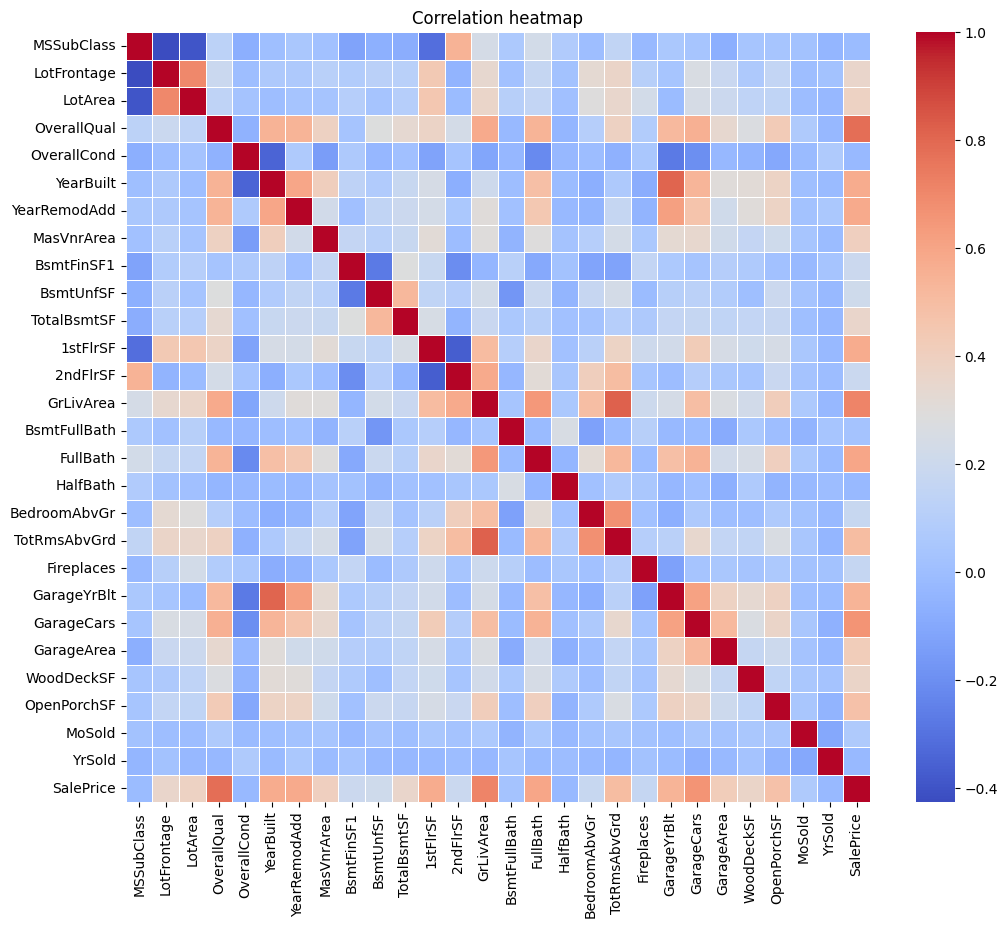

In [18]:
correlation_matrix=df_numerical.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=.5)
plt.title('Correlation heatmap')


plt.show()




**Let us identify the features strongly correlated and with a 3 steps process let us decide if we have to remove them:**

1. Identification based on the correlation matrix
2. Confirm the significance of the correlation through a statistical test
3. If the correlation is confirmed we remove the feature less correlated with our target variable

This procedure will reduce the parameters of our model without losing relevant informations and reducing the collinearity of the features which affects in negative way many regression models.



In [19]:
df_corr = df_numerical.copy()
df_corr.drop('SalePrice', axis=1, inplace=True)
correlation_matrix=df_corr.corr()
corr_threshold = 0.7
corr_list_above_T = []


for col_1 in correlation_matrix:
    for col_2 in correlation_matrix:
        if col_1 < col_2 and abs(correlation_matrix.loc[col_1, col_2]) > corr_threshold:
            corr_couple=(col_1, col_2)
            corr_list_above_T.append(corr_couple)
            

print(corr_list_above_T)


[('LotArea', 'LotFrontage'), ('GrLivArea', 'TotRmsAbvGrd'), ('GarageYrBlt', 'YearBuilt')]


We found explicitly all the features which present a correlation above our threshold, so we accomplish our first step. For the second step we have to understand what statistical test we can perform to understand the statistical significance of the correlation. 

We are going to consider two tests:
1. **Spearman test**: non parametric test, with null hypotesis of 0 correlation between the variables
2. **Pearson test**: assumptions of linear variables distributed normally with homogeneous variances with null hypotesis of 0 correlation. 

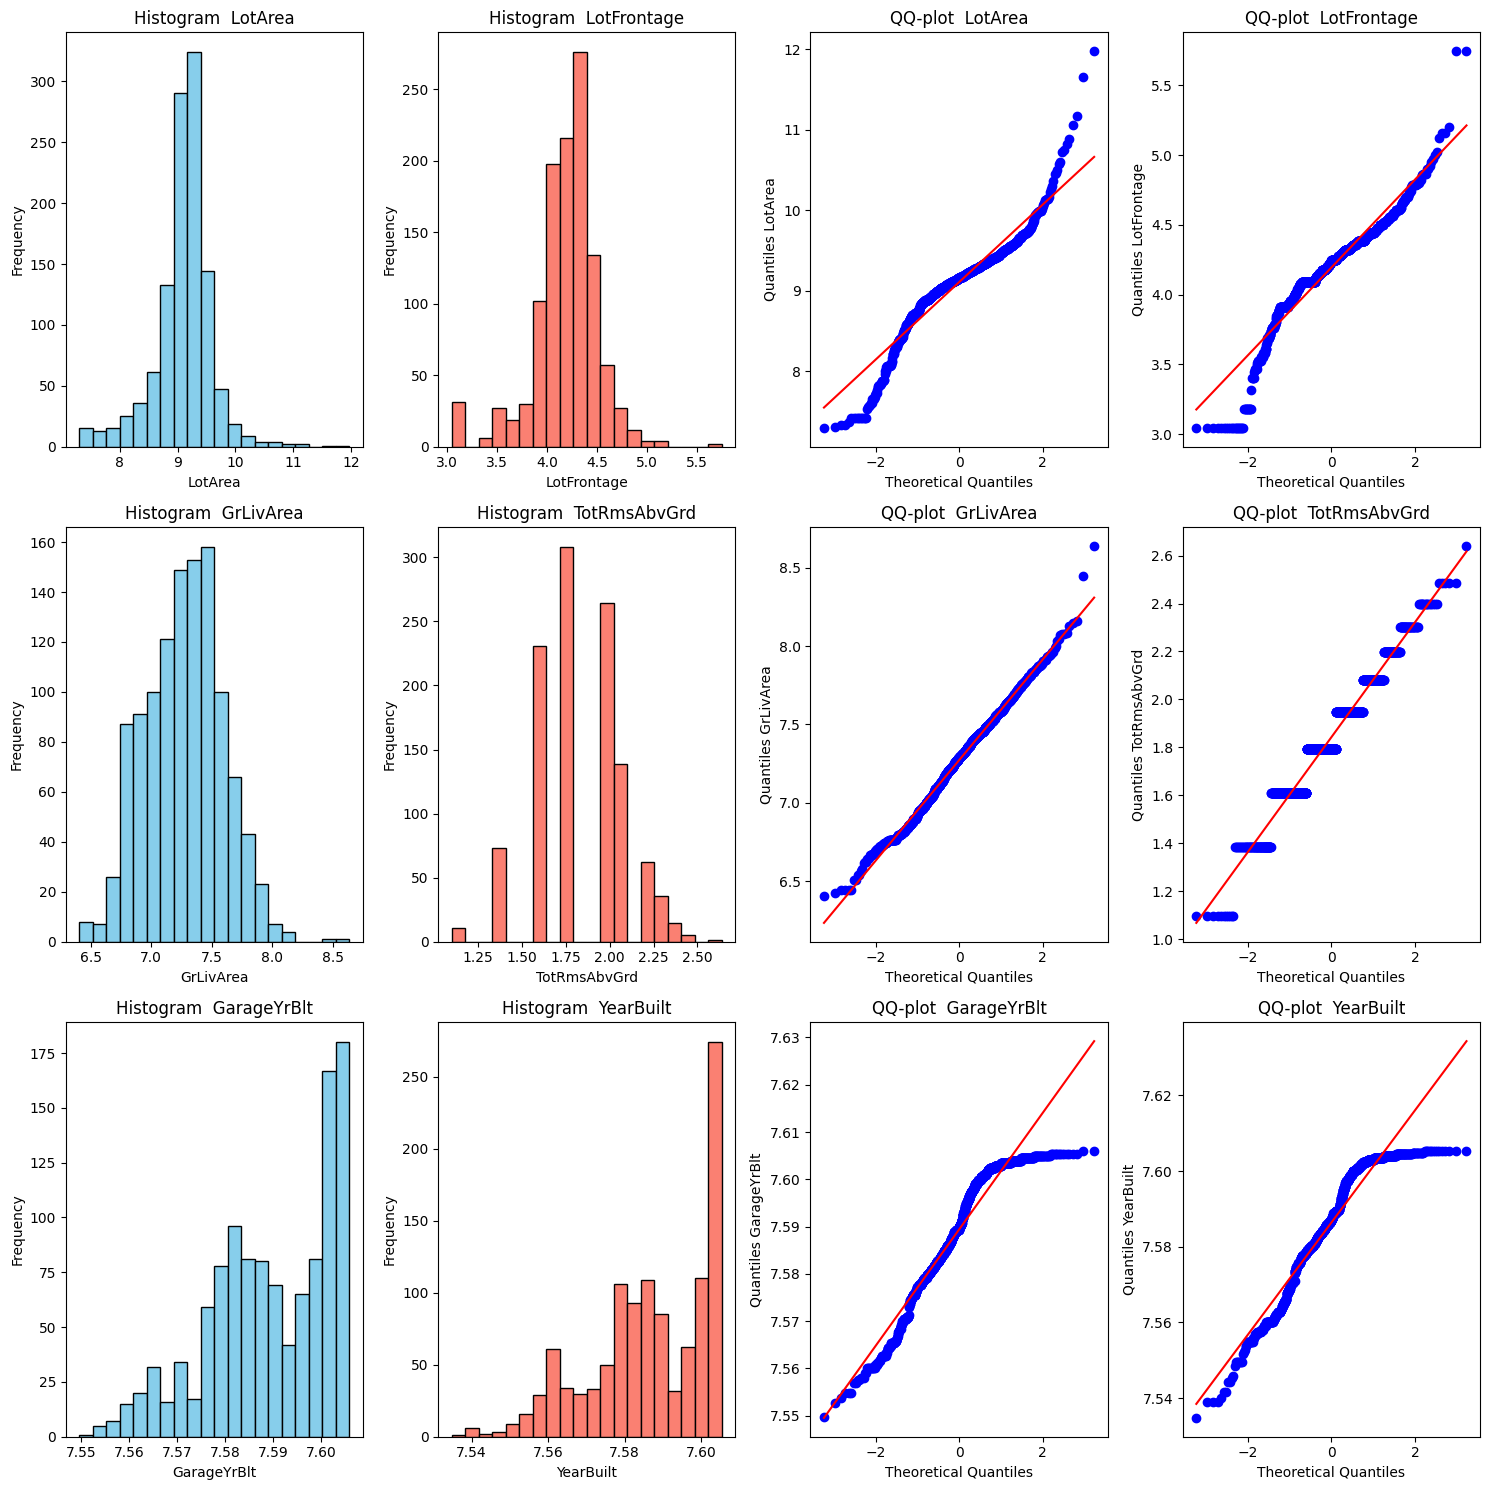

In [20]:
num_columns_subplot=4
num_rows_subplot = len(corr_list_above_T)
fig, axs = plt.subplots(num_rows_subplot, num_columns_subplot, figsize=(15, 5 * num_rows_subplot))


axs = axs.flatten()


for idx, (col1, col2) in enumerate(corr_list_above_T):
   
    axs[idx * num_columns_subplot].hist(df_numerical[col1], bins=20, color='skyblue', edgecolor='black')
    axs[idx * num_columns_subplot].set_title(f'Histogram  {col1}')
    axs[idx * num_columns_subplot].set_xlabel(col1)
    axs[idx * num_columns_subplot].set_ylabel('Frequency')
    
   
    axs[idx * num_columns_subplot + 1].hist(df_numerical[col2], bins=20, color='salmon', edgecolor='black')
    axs[idx * num_columns_subplot + 1].set_title(f'Histogram  {col2}')
    axs[idx * num_columns_subplot + 1].set_xlabel(col2)
    axs[idx * num_columns_subplot + 1].set_ylabel('Frequency')
    
    
    probplot(df_numerical[col1], plot=axs[idx * num_columns_subplot + 2], fit=True)
    axs[idx * num_columns_subplot + 2].set_title(f'QQ-plot  {col1}')
    axs[idx * num_columns_subplot + 2].set_xlabel('Theoretical Quantiles')
    axs[idx * num_columns_subplot + 2].set_ylabel(f'Quantiles {col1}')
    
    
    probplot(df_numerical[col2], plot=axs[idx * num_columns_subplot + 3],fit=True)
    axs[idx * num_columns_subplot + 3].set_title(f'QQ-plot  {col2}')
    axs[idx * num_columns_subplot + 3].set_xlabel('Theoretical Quantiles')
    axs[idx * num_columns_subplot + 3].set_ylabel(f'Quantiles {col2}')


plt.tight_layout()
plt.show()

**GarageYrBlt** vs **YearBuilt**

Let's start from the couple GarageYrBlt and YearBuilt: the histogram of both features is far from the one we expect from normally distributed variables, however the similirities are evident. Moreover it seems more than reasonable to assume that the two variables provide the same informations since in general the year in which the garage is built is the same as the one in which the property is built. Let's confirm this with the Spearman test

**GrLivArea** vs **TotRmsAbvGrd**

The couple GrLivArea and TotRmsAbvGrd look like good candidates for the Pearson test, however TotRmsAbvGrd is not continuous, for this reason we prefer to rely on the Spearman test.

**LotArea** vs **LotFrontage**

Even though the histograms seem to follow a normal distribution, the QQ-plots show evident departure from the theoretical quantiles of a Gaussian. For this reason we choose again the Spearman test.


In [21]:
from scipy.stats import spearmanr
p_value_T = 0.05
p_value_below_T = []


for column_pairs in corr_list_above_T:
    corr, p_value = spearmanr(df_numerical[column_pairs[0]], df_numerical[column_pairs[1]])
    
    if p_value < p_value_T:
       p_value_below_T.append(column_pairs)
    
print(p_value_below_T)
    
     
    

[('LotArea', 'LotFrontage'), ('GrLivArea', 'TotRmsAbvGrd'), ('GarageYrBlt', 'YearBuilt')]


Since the p_value for all couple of variables is below the choosen threshold, we have to refuse the null hypotesis (no correlation) to accept the alternative hypotesis (no statistical evidence against correlation).

At this point we just have to evaluate the variable of the couple with a lower correlation with the target variable and remove it from the database.

In [22]:
target_variable = "SalePrice"
corr_dummy_variable = 2
column_to_drop = ''

for column_pair in p_value_below_T:
    for column in column_pair:
        corr = df_numerical[target_variable].corr(df_numerical[column])
       
        if corr<corr_dummy_variable:
            column_to_drop = column
            corr_dummy_variable = df_numerical[target_variable].corr(df_numerical[column])
    
    corr_dummy_variable = 2
    print(column_to_drop)
    df_numerical.drop(column_to_drop, axis=1, inplace=True)
    df_numerical_test.drop(column_to_drop, axis=1, inplace=True)
                   
        

LotFrontage
TotRmsAbvGrd
GarageYrBlt


Let's check the database to be sure that we successfully removed the columns

In [23]:
print(df_numerical.columns)
print(df_numerical_test.columns)

Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'Fireplaces', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')
Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'Fireplaces', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')


**Variables weakly correlated with the target**

In the second part of the features selection, we analyze the variables weakly correlated with the target. Again we introduce a threshold that shoul be considered as a parameter.
First we will print a list of variables which exibit a correlation below the threshold to analyze in a second step the statistical significance of the correlation

In [24]:
target_variable="SalePrice"
corr_threshold=0.1
weakly_corr_to_target=[]


for column in df_numerical.columns:
    
    if df_numerical[target_variable].corr(df_numerical[column])<= corr_threshold:
        weakly_corr_to_target.append(column)


print(weakly_corr_to_target)

['MSSubClass', 'OverallCond', 'BsmtFullBath', 'HalfBath', 'MoSold', 'YrSold']


After the identification we have to control if the correlation of these variables with the target shows a statistical significance. As we did previously to identify a proper statistical test let us study the distribution and QQ-plots of these columns

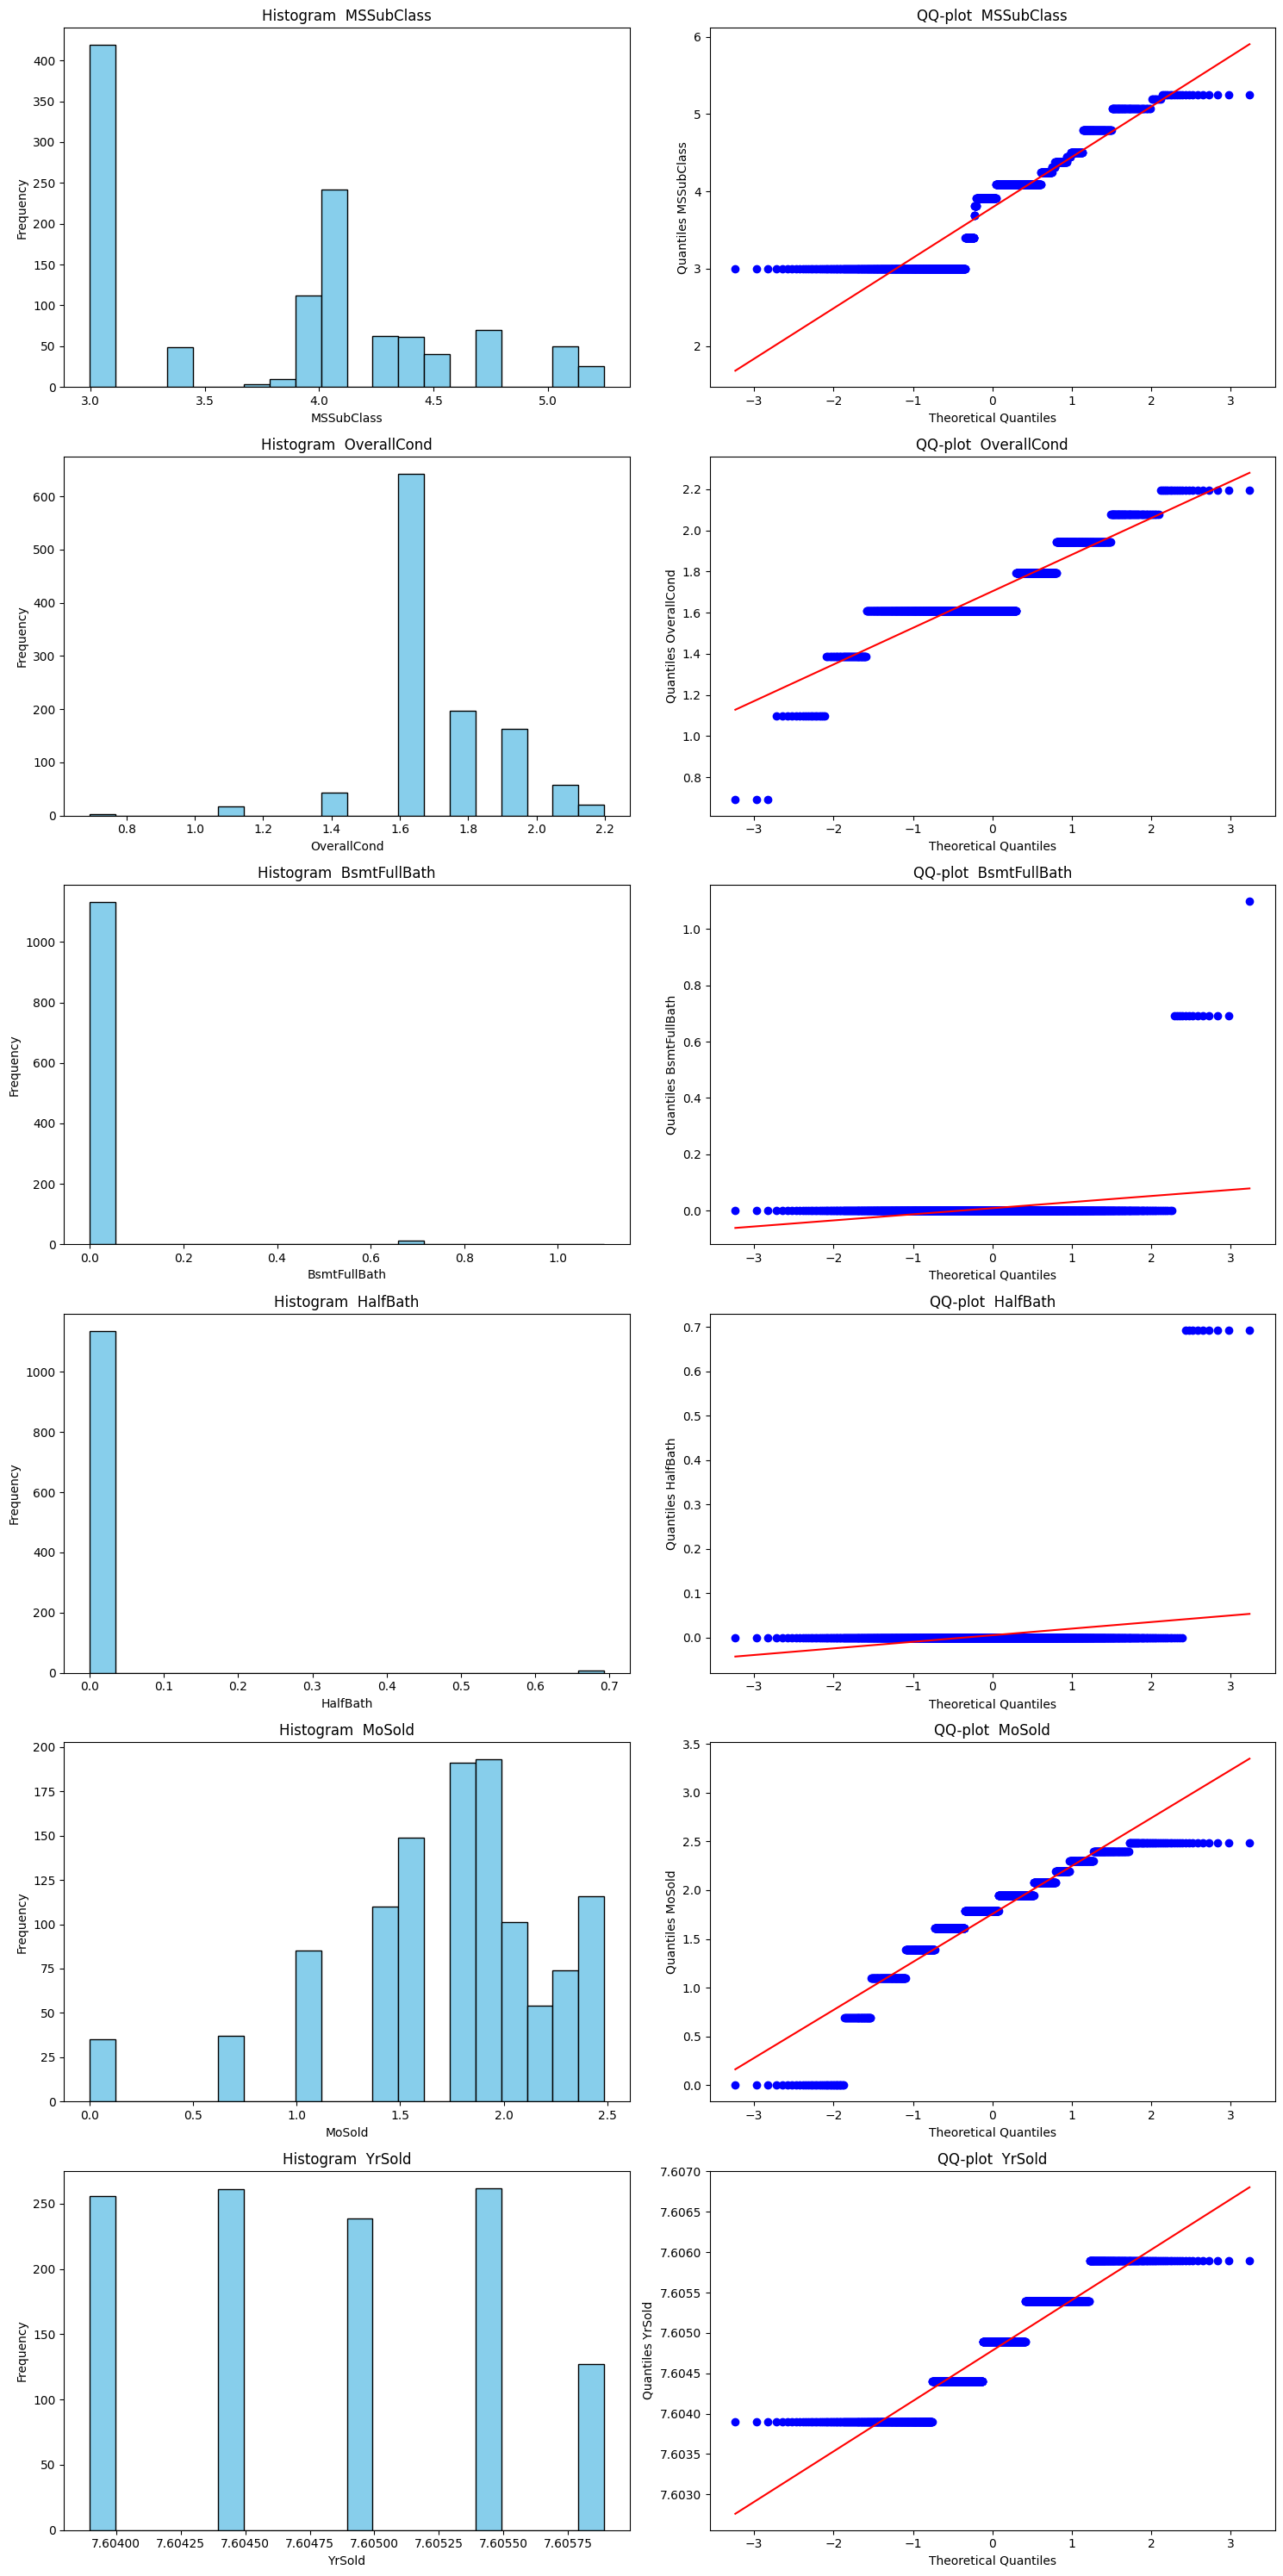

In [25]:
num_columns_subplot=2
num_rows_subplot = len(weakly_corr_to_target)
fig, axs = plt.subplots(num_rows_subplot, num_columns_subplot, figsize=(15, 5 * num_rows_subplot))


axs = axs.flatten()


for idx, column in enumerate(weakly_corr_to_target):
   
    
    axs[idx*num_columns_subplot].hist(df_numerical[column], bins=20, color='skyblue', edgecolor='black')
    axs[idx*num_columns_subplot].set_title(f'Histogram  {column}')
    axs[idx*num_columns_subplot].set_xlabel(column)
    axs[idx*num_columns_subplot].set_ylabel('Frequency')
    
    
    probplot(df_numerical[column], plot=axs[idx*num_columns_subplot+1],fit=True)
    axs[idx*num_columns_subplot+1].set_title(f'QQ-plot  {column}')
    axs[idx*num_columns_subplot+1].set_xlabel('Theoretical Quantiles')
    axs[idx*num_columns_subplot+1].set_ylabel(f'Quantiles {column}')


plt.tight_layout()
plt.show()

Nothing even close to a normal distribution, let's go with the spearman test and let us remove the columns with a p_value higher than a threshold (In the Spearman test the null hypotesis is no correlation). Without a confirmation of the statistical significance of the test (p_value higher then the threshold we will keep the columns).

In [26]:
p_threshold=0.05


for column in weakly_corr_to_target:
    corr, p_value = spearmanr(df_numerical[column], df_numerical[target_variable])
    
    if p_value > p_threshold:
       print(column)
       df_numerical.drop(column, axis=1, inplace=True)
       df_numerical_test.drop(column, axis=1, inplace=True)

MSSubClass
BsmtFullBath
HalfBath
YrSold


After the feature selections we have a database ready to be used. let's explore our final result.

<Axes: >

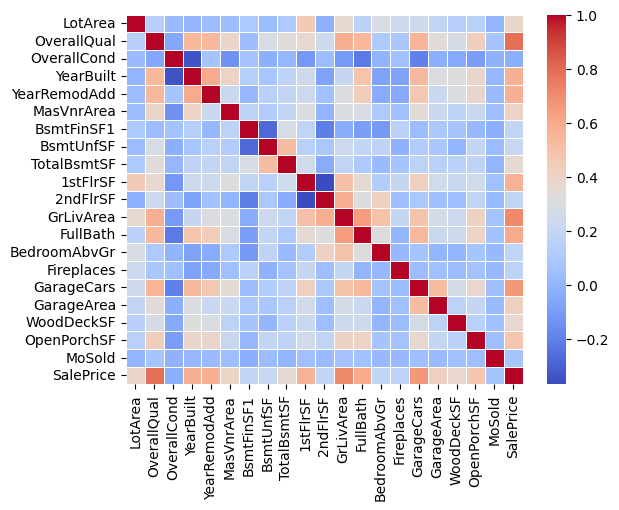

In [27]:
final_corr_matrix = df_numerical.corr()
sns.heatmap(data=final_corr_matrix, annot=False, cmap='coolwarm', linewidths=.5)

# CATEGORICAL FEATURES

It's time to analyze the categorical features, first of all I'm gonna take care of the low variance columns, in the categorical world by low variance columns I mean the columns where a relevant percentage of values for each column lie on a single channel. I will introduce a further threshold and eliminate the columns with a percentage of values in one channel above the threshold. I'm gonna use as threshold the same value of the one I used for the numerical columns.

In [28]:
percentage_T = 85


for column in df_categorical.columns:
    values = df_categorical.groupby(column).size()
    percentages = (values/values.sum()) * 100
   
    if any(percentage > percentage_T for percentage in percentages):
        print(column)
        df_categorical.drop(column, axis=1, inplace=True)

        
    

Street
LandContour
Utilities
LandSlope
Condition1
Condition2
RoofMatl
ExterCond
BsmtCond
BsmtFinType2
Heating
CentralAir
Electrical
Functional
GarageQual
GarageCond
PavedDrive
MiscFeature
SaleType


# MISSING VALUES

From the informations on the database it seems that there are some columns with a really high percentage of missing values, again we are going to introduce a threshold, I am going to remove columns with a percentage of missing values above the threshold. After this I will consider eventual remaining columns with missing values to choose an appropriate imputation.


In [29]:
missing_percentage_T = 90


for column in df_categorical.columns:
    missing_values = df_categorical[column].isna().sum()
    missing_percentage = (missing_values / df_categorical.shape[0]) * 100
    
    if missing_percentage > missing_percentage_T:
        print(column)
        df_categorical.drop(column, axis=1, inplace=True)


df_categorical.info()

Alley
PoolQC
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1432 entries, 0 to 1431
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSZoning       1432 non-null   object
 1   LotShape       1432 non-null   object
 2   LotConfig      1432 non-null   object
 3   Neighborhood   1432 non-null   object
 4   BldgType       1432 non-null   object
 5   HouseStyle     1432 non-null   object
 6   RoofStyle      1432 non-null   object
 7   Exterior1st    1432 non-null   object
 8   Exterior2nd    1432 non-null   object
 9   MasVnrType     578 non-null    object
 10  ExterQual      1432 non-null   object
 11  Foundation     1432 non-null   object
 12  BsmtQual       1397 non-null   object
 13  BsmtExposure   1396 non-null   object
 14  BsmtFinType1   1397 non-null   object
 15  HeatingQC      1432 non-null   object
 16  KitchenQual    1432 non-null   object
 17  FireplaceQu    756 non-null    object
 18  GarageType     

Since there are columns with still a fairly high percentage of missing values, I prefer to first transform the column in numerical data and then proceed with the imputation. To convert the categorical data to numerical we are going to use the one hot encoding method by dropping the first column to avoid a strong multicollinearity that can represent a big problem for example for a linear regression.

The choice of the one hot encoding is due to the fact that the remaining categorical features doesn't seem to be ordinal variable.

In [30]:
from sklearn.preprocessing import OneHotEncoder


encoder = OneHotEncoder(drop='first', sparse=False)
encoder.fit(df_categorical)
onehot_encoded = encoder.transform(df_categorical)


columns = encoder.get_feature_names_out(df_categorical.columns)
onehot_df = pd.DataFrame(onehot_encoded, columns=columns)


df_categorical = df_categorical.drop(df_categorical.columns, axis=1, inplace=True)
df_categorical = pd.concat([df_categorical, onehot_df], axis=1)


df_categorical.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1432 entries, 0 to 1431
Columns: 135 entries, MSZoning_FV to SaleCondition_Partial
dtypes: float64(135)
memory usage: 1.5 MB


c:\Users\aszew\miniconda3\envs\my_env\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# AVOIDING DATA LEAKAGE 2

Before imputing the missing values we have again to avoid data leakage by splitting the categorical database in a test and training part.

In [31]:
X_train, X_test = train_test_split(df_categorical, test_size=0.2, random_state=42)


df_categorical = X_train.copy()
df_categorical_test = X_test.copy()


The method we decided to use even in this case is a KNN imputer

In [32]:
imputer = KNNImputer()


df_categorical = pd.DataFrame(imputer.fit_transform(df_categorical), columns=df_categorical.columns)
df_categorical_test = pd.DataFrame(imputer.fit_transform(df_categorical_test), columns=df_categorical_test.columns)


df_categorical.info()
df_categorical_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1145 entries, 0 to 1144
Columns: 135 entries, MSZoning_FV to SaleCondition_Partial
dtypes: float64(135)
memory usage: 1.2 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287 entries, 0 to 286
Columns: 135 entries, MSZoning_FV to SaleCondition_Partial
dtypes: float64(135)
memory usage: 302.8 KB


**Creation of the training and validation full database to assess the best model to fit the database**

In [33]:
df_train = pd.concat([df_numerical, df_categorical], axis=1)
df_validation = pd.concat([df_numerical_test, df_categorical_test], axis=1)


df_train.info()
df_validation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1145 entries, 0 to 1144
Columns: 156 entries, LotArea to SaleCondition_Partial
dtypes: float64(156)
memory usage: 1.4 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287 entries, 0 to 286
Columns: 156 entries, LotArea to SaleCondition_Partial
dtypes: float64(156)
memory usage: 349.9 KB


# LINEAR REGRESSION

**hypotesis**

Before implementing a linear regression let us remind the hypotesis that should be satisfied to build a reliable model.

1. **Linearity**: between the features and the target we need on average a linear relation
2. **Residual normally distributed**: more than an hypotesis it is a requirement, since to study the significance of the parameter that we are going to estimate it is better to work with a distribution with well known confidence intervals. In theory in a linear regression context since the features are considered non random and we've already verified that the target variable follow a normal distribution, we should find that even the residual follow a normal distribution, since the normality is preserved through affine transformation, but in practice since we never work with a exact normal distribution we will have to check if this condition is preserved.
3. **Omoschedasticity**: Residual of the model exibit a constant variance.
4. **Non-multicollinearity** The features should not exibit a strong correlation among themselves

just a quick reminder, when we are working with real data is hard to expect that these hypotesis will be exactly satisfied, so we have to be flexible to understand that is almost impossible to find the perfect algorithm but the best for a given dataset. 




**Non-multicollinearity**

We've already addressed the issue of correlated features, if we want to further reduce the collinearity we have just to adjust the parameter introduced previously. 

**linearity**

To verify if this condition is satisified let's plot the diagrams of all the features in the dataset vs the target variable, again it is perfectly fine to don't expect a perfect linearity of al the features, however this is something that should be considered when we want to improve the model with a different algorithm.

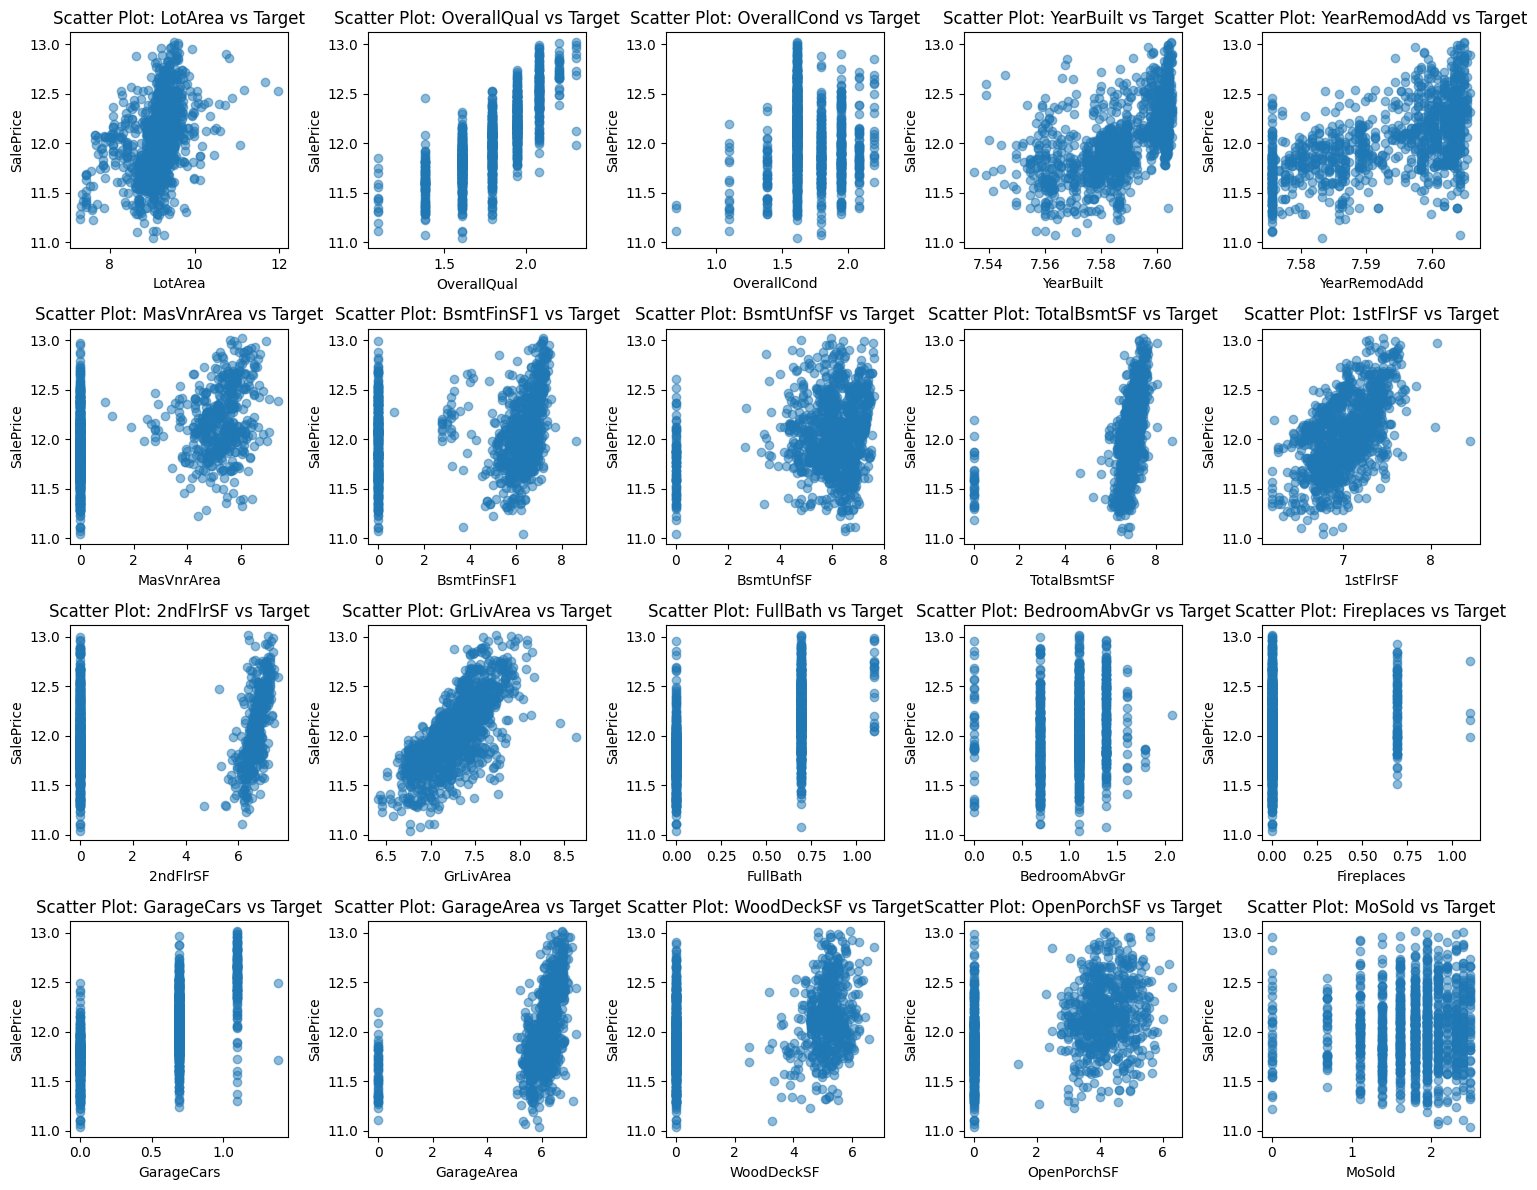

In [34]:
num_rows = 4
num_cols = 5


fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))


axs = axs.flatten()


for i, column in enumerate(df_numerical.columns[:-1]):
    if column!= "SalePrice":
       ax = axs[i]
       ax.scatter(df_numerical[column], df_numerical['SalePrice'], alpha=0.5)
       ax.set_title(f'Scatter Plot: {column} vs Target')
       ax.set_xlabel(column)
       ax.set_ylabel('SalePrice')


for i in range(len(df_numerical.columns) - 1, num_rows * num_cols):
    fig.delaxes(axs[i])


plt.tight_layout()
plt.show()

The variables strongly correlated with the target exibit a behaviour that can be considered acceptable to implement a linear regression.

**Normality of the residual** and **omoschedasticity**

To investigate if these hypotesis are satisfied we have to implement a linear regression and study the residual of the model, this is exactly what we are going to do.

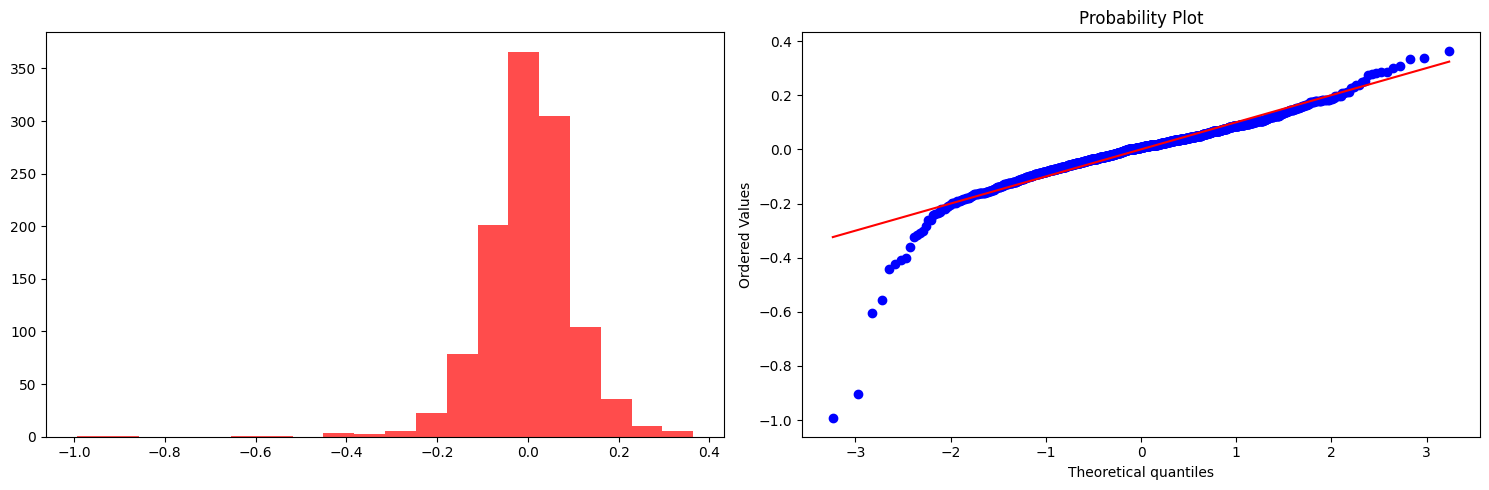

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X_train = df_train.drop('SalePrice', axis=1)
y_train = df_train['SalePrice']


model = LinearRegression()
model.fit(X_train, y_train)


y_train_pred = model.predict(X_train)
residuals = y_train - y_train_pred


fig,ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].hist(residuals, bins=20, color='red', alpha=0.7)
probplot(residuals, plot=ax[1], fit=True)


plt.tight_layout()
plt.show()

The distribution is really nice except for some values of the residual on the left tail of the distribution that we should investigate to understand why they are leading to these errors.

In [36]:
df_train['residuals'] = residuals

possible_outliers = df_train[np.abs(df_train['residuals']) >= 0.4].count()
print(possible_outliers)


LotArea                  8
OverallQual              8
OverallCond              8
YearBuilt                8
YearRemodAdd             8
                        ..
SaleCondition_Alloca     8
SaleCondition_Family     8
SaleCondition_Normal     8
SaleCondition_Partial    8
residuals                8
Length: 157, dtype: int64


There are just eight rows, so we can remove them assuming they don't represent the majority of the data. Of course it would be better to have stronger reason to do this, however just by cutting 8 rows we may have a much better database to implement a linear regression, by not losing too many relevant informations.

In [37]:
df_train = df_train[np.abs(df_train['residuals']) <= 0.4]
df_train = df_train.reset_index(drop=True)


df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1137 entries, 0 to 1136
Columns: 157 entries, LotArea to residuals
dtypes: float64(157)
memory usage: 1.4 MB


Perfect, let's see if the histogram and the QQ-plot of the residuals improved.

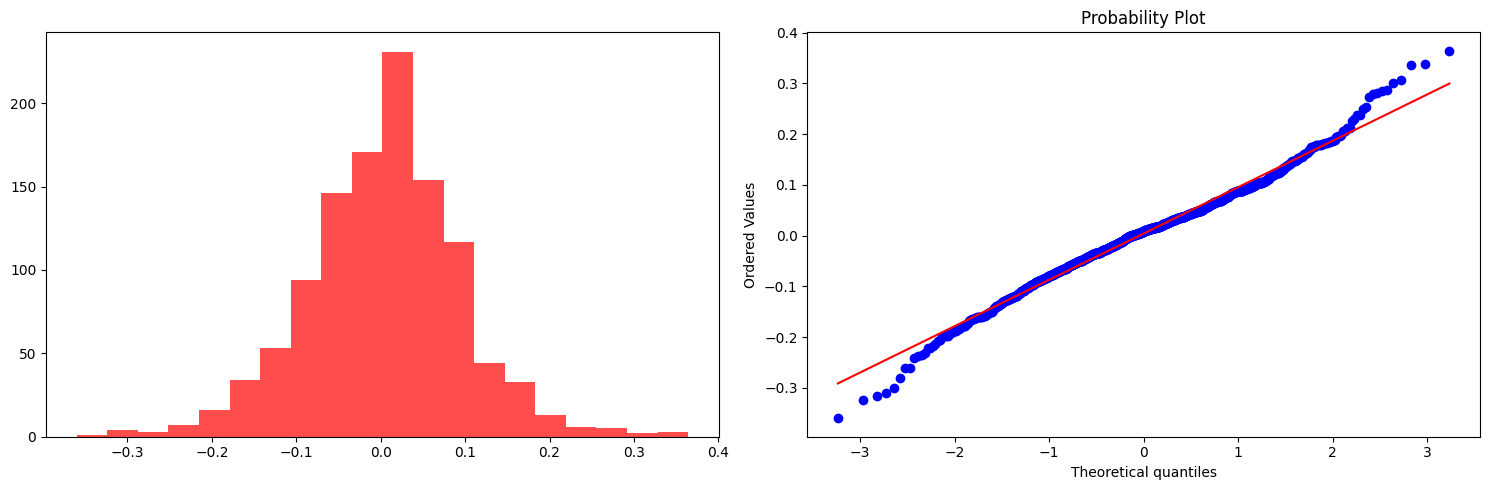

In [38]:
fig, axs=plt.subplots(1,2,figsize=(15,5))


axs[0].hist(df_train['residuals'], bins=20, color='red', alpha=0.7)
probplot(df_train['residuals'], plot=axs[1], fit=True)


plt.tight_layout()
plt.show()

Beautiful! 

Let's fit our model to the new database and let's verify if the omoschedasticity is approximately satisfied by exploring a scatter plot of the residuals vs the target variable.

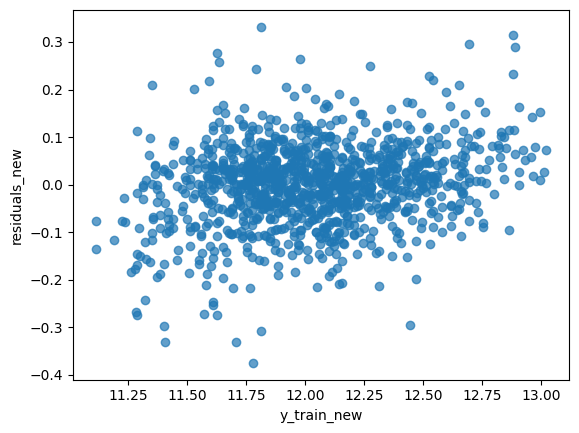

In [39]:
X_train_new = df_train.drop(['SalePrice', 'residuals'], axis=1)
y_train_new = df_train['SalePrice']


model = LinearRegression()
model.fit(X_train_new, y_train_new)


y_new_train_pred = model.predict(X_train_new)
residuals_new = y_train_new - y_new_train_pred


plt.scatter(y_train_new, residuals_new, alpha=0.7)
plt.xlabel('y_train_new')
plt.ylabel('residuals_new')


plt.show()



In [40]:
for column in df_train:
    if column not in df_validation:
        print(column)

residuals


The dataset doesn't exibit a clear omoschedasticity, this might increase the errors associated to a linear regression, more advanced model less sensible to heteroschedasticity might be considered.

# MODEL SELECTION

We noticed that the data exibit properties compatibles for the implementation of a linear regression. However we may explore different models less sensible for example to the requirement of homoschedasticity and more advanced models to see if we can improve our predictions.

In [41]:
from sklearn.linear_model import LinearRegression, Ridge, HuberRegressor, Lasso,ElasticNet
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error



X_train_new = df_train.drop(['SalePrice','residuals'], axis=1)
X_test = df_validation.drop('SalePrice', axis=1)
y_test = df_validation['SalePrice']


models = [
    ('linear regression', LinearRegression()),
    ('Polynomial regression', make_pipeline(PolynomialFeatures(degree=2), LinearRegression())),
    ('Ridge regression', Ridge()),
    ('Random Forest Regressor', RandomForestRegressor()),
    ('LASSO regression', Lasso()),
    ('Elastic Net regression', ElasticNet()),
    ('Support Vector Regression', SVR()),
    ('XGBoost Regressor', XGBRegressor())
    
    ]


for name_model, model in models:
   
      model.fit(X_train_new, y_train_new)
      predictions = model.predict(X_test)
      mse = mean_squared_error(y_test, predictions)
      
      print(f"MSE ({name_model}): {mse}")



MSE (linear regression): 0.011041627336937216
MSE (Polynomial regression): 0.03116150812280201
MSE (Ridge regression): 0.011690147921720353
MSE (Random Forest Regressor): 0.01735316810701715
MSE (LASSO regression): 0.12538106101378363
MSE (Elastic Net regression): 0.12538106101378363
MSE (Support Vector Regression): 0.016025646857133865
MSE (XGBoost Regressor): 0.01583618302732948


Given the results by evaluating the mean squared error, the choice of a linear regression is pretty easy: not only it provide the best performance but it is the most simple and flexible models among the ones we considered

In [42]:
import pickle


model = LinearRegression()
model.fit(X_train_new, y_train_new)
predictions = model.predict(X_test)


with open('regression_model.pkl','wb') as model_file:
  pickle.dump(model,model_file)

In [43]:
df_train.to_csv('Complete_housing_cleaned_onehot_splitted.csv')